In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize
import nltk
from string import punctuation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pickle

In [2]:
stop_words = nltk.corpus.stopwords.words('english')
token_space = tokenize.WhitespaceTokenizer()
token_punct = tokenize.WordPunctTokenizer()

def transformSentence(list_of_sentences):
    
    sentences_after_stopwords = list()
    
    for sentence in list_of_sentences:
        new_sentence = list()
        words_from_sentence = token_space.tokenize(sentence)
        for word in words_from_sentence:
            if word not in stop_words:
                new_sentence.append(word)
        sentences_after_stopwords.append(" ".join(new_sentence))

    sentences_after_stopwords_puncts = list()

    for sentence in sentences_after_stopwords:
        for punct_to_change in punctuation:
            sentence = sentence.replace(punct_to_change,"")
        sentences_after_stopwords_puncts.append(sentence)

    sentences_after_stopwords_puncts_lower = list()

    for sentence in sentences_after_stopwords_puncts:
        sentence = sentence.lower()
        sentences_after_stopwords_puncts_lower.append(sentence)

    stop_words_no_accent = list()

    for word in stop_words:
        for punct_to_change in punctuation:
            word = word.replace(punct_to_change,"")
        stop_words_no_accent.append(word)
    
    sentences_after_stopwords_puncts_lower_stopwords = list()

    for sentence in sentences_after_stopwords_puncts_lower:
        new_sentence = list()
        words_from_sentence = token_space.tokenize(sentence)
        for word in words_from_sentence:
            if word not in stop_words_no_accent:
                new_sentence.append(word)
        sentences_after_stopwords_puncts_lower_stopwords.append(" ".join(new_sentence))

    sentences_after_stopwords_puncts_lower_stopwords_number = list()

    for sentence in sentences_after_stopwords_puncts_lower_stopwords:
        new_sentence = list()
        words_from_sentence = token_space.tokenize(sentence)
        for word in words_from_sentence:
            if not word.isnumeric():
                new_sentence.append(word)
            else:
                new_sentence.append("0")
        sentences_after_stopwords_puncts_lower_stopwords_number.append(" ".join(new_sentence))

    return sentences_after_stopwords_puncts_lower_stopwords_number

In [3]:
colnames=['output','text']
df = pd.read_csv('all-data.csv', names=colnames, encoding = "ISO-8859-1", header=None)
all_sentences = [text for text in df.text]
words = ' '.join(all_sentences)

treated_sentences = transformSentence(list(df.text))

tfidf = TfidfVectorizer(lowercase=False,max_features=600)
vector_tfidf = tfidf.fit_transform(treated_sentences)

smote = SMOTE(random_state=100)
X_resampled, Y_resampled = smote.fit_resample(vector_tfidf,df.output)

test_size=0.1
X_train,X_test,Y_train,Y_test = train_test_split(X_resampled,Y_resampled,random_state = 100,test_size=test_size)

In [4]:
randomForest = RandomForestClassifier(n_estimators = 300,max_depth=None, min_samples_leaf = 1, max_features = 'log2', criterion = 'entropy', random_state = 100)
randomForest.fit(X_train,Y_train)
randomForest.score(X_test,Y_test)

0.8761574074074074

In [5]:
proba_results = pd.DataFrame(randomForest.predict_proba(X_test),columns=randomForest.classes_)
proba_results['highest'] = proba_results[["negative", "neutral", "positive"]].max(axis=1)
proba_results['prediction'] = randomForest.predict(X_test)
proba_results['answer'] = list(Y_test)


In [6]:
proba_results['accuracy'] = np.where(proba_results['prediction']==proba_results['answer'], 1, 0)

In [7]:
proba_results.head()

,negative,neutral,positive,highest,prediction,answer,accuracy
0,0.710000,0.130000,0.160000,0.710000,negative,negative,1
1,0.093333,0.026667,0.880000,0.880000,positive,positive,1
2,0.333711,0.255167,0.411122,0.411122,positive,neutral,0
3,0.020286,0.882524,0.097190,0.882524,neutral,neutral,1
4,0.010530,0.068890,0.920580,0.920580,positive,positive,1


In [8]:
baseline_highest = 0.90

query = ('highest >= {}').format(baseline_highest)
proba_results_filtered = proba_results.query(query)
print("classifing",len(proba_results_filtered.accuracy),"from",len(proba_results.accuracy))
print("precision:",proba_results_filtered.accuracy.sum()/len(proba_results_filtered.accuracy))

classifing 195 from 864
precision: 0.9897435897435898


In [9]:
list_for_graph = []

for baseline in [i/20 for i in np.arange(1,21)]:
    query = ('highest >= {}').format(baseline)
    proba_results_filtered = proba_results.query(query)
    precision = proba_results_filtered.accuracy.sum()/len(proba_results_filtered.accuracy)
    list_for_graph.append([baseline,precision])

dataframe_for_graph = pd.DataFrame(list_for_graph,columns=['baseline','precision'])

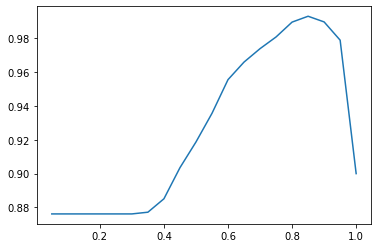

In [10]:
plt.plot(dataframe_for_graph['baseline'],dataframe_for_graph['precision'])

In [11]:
randomForest = RandomForestClassifier(n_estimators = 300,max_depth=None, min_samples_leaf = 1, max_features = 'log2', criterion = 'entropy', random_state = 100)
randomForest.fit(X_resampled,Y_resampled)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=300, random_state=100)

In [12]:
output = open('financial-sentiment-model.sav','wb')
pickle.dump(randomForest,output)
output.close()